In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
#Модели
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor
from lightgbm import LGBMRegressor
#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

import warnings

In [3]:
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

## Подготовка данных

In [4]:
###data = pd.read_csv('C:/Users/Mikhail/autos.csv')
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('C:/Users/Mikhail/оформление/Определение стоимости автомобилей/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [6]:
def miss_sorted(data):
    report = data.isna().sum().to_frame()
    report = report.rename(columns = {0: 'missing_values'})
    report['% of total'] = (report['missing_values'] / data.shape[0]).round(2)
    print(report.sort_values(by = 'missing_values', ascending = False))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [9]:
miss_sorted(data)

                   missing_values  % of total
NotRepaired                 71154        0.20
VehicleType                 37490        0.11
FuelType                    32895        0.09
Gearbox                     19833        0.06
Model                       19705        0.06
DateCrawled                     0        0.00
Price                           0        0.00
RegistrationYear                0        0.00
Power                           0        0.00
Kilometer                       0        0.00
RegistrationMonth               0        0.00
Brand                           0        0.00
DateCreated                     0        0.00
NumberOfPictures                0        0.00
PostalCode                      0        0.00
LastSeen                        0        0.00


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

1. Нет фотографий - можно убрать столбец
2. NotRepaired\VehicleType\FuelType\Gearbox\Model имеют пропуски.
3. sonstige_autos - c нем. другие
4. У нас есть категориальный признаки с большим количеством именований

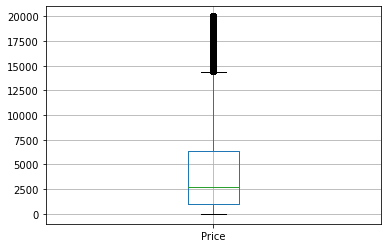

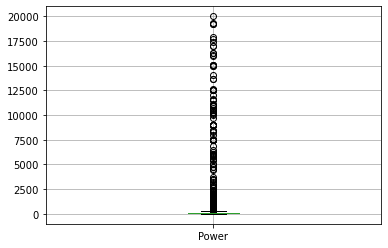

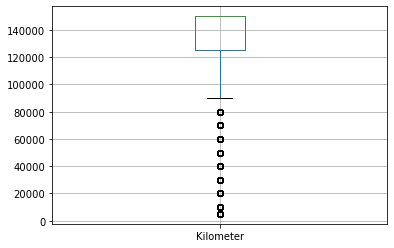

In [11]:
plot_list = ['Price', 'Power', 'Kilometer']

for col in plot_list:
    data.boxplot(column=col)
    plt.show()

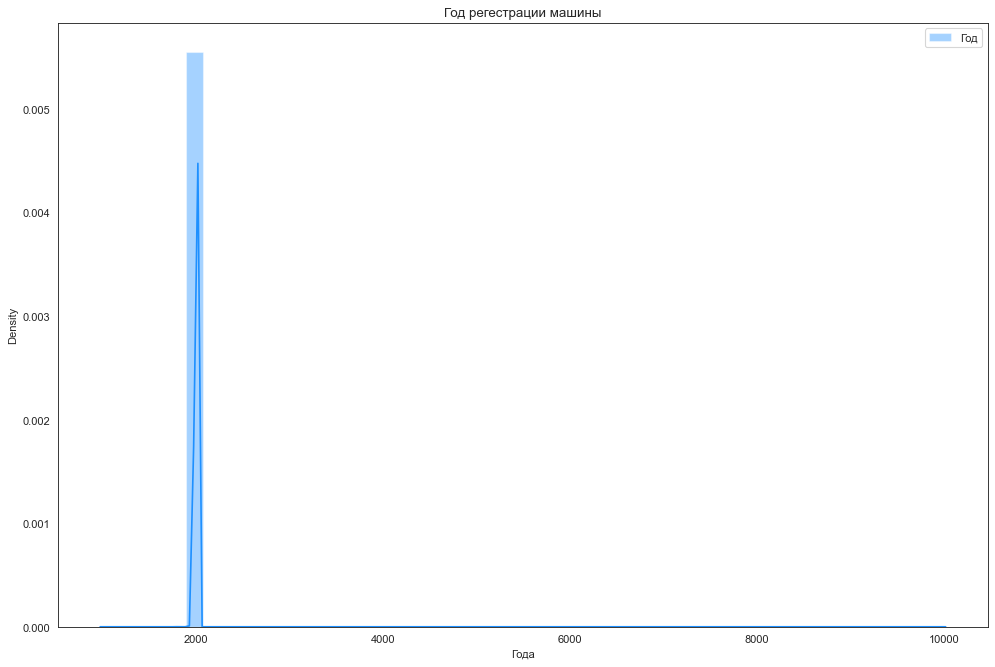

In [15]:
sns.set_style("white")

# Import data
df = data
x1 = df['RegistrationYear']

# Plot
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(15,10), dpi= 80)
sns.distplot(x1, color="dodgerblue", label="Год")
plt.xlabel('Года')
plt.legend();
plt.title('Год регестрации машины');

1. Машины 50-ых и 60-ых возможно существуют(рариетет и т.д), но машины с регистрацией далее 21года невозможно и их стоит убрать, это выбросы.

In [16]:
data = data.query('RegistrationYear < 2021')
data.shape

(354264, 16)

In [17]:
data.query('Kilometer < 80000').count()

DateCrawled          43107
Price                43107
VehicleType          38291
RegistrationYear     43107
Gearbox              39405
Power                43107
Model                39797
Kilometer            43107
RegistrationMonth    43107
FuelType             38572
Brand                43107
NotRepaired          35391
DateCreated          43107
NumberOfPictures     43107
PostalCode           43107
LastSeen             43107
dtype: int64

In [18]:
data.query('Price > 15000').count()

DateCrawled          14878
Price                14878
VehicleType          14444
RegistrationYear     14878
Gearbox              14671
Power                14878
Model                14411
Kilometer            14878
RegistrationMonth    14878
FuelType             14459
Brand                14878
NotRepaired          13886
DateCreated          14878
NumberOfPictures     14878
PostalCode           14878
LastSeen             14878
dtype: int64

In [19]:
data.query('Price == 0').count()

DateCrawled          10753
Price                10753
VehicleType           7032
RegistrationYear     10753
Gearbox               8290
Power                10753
Model                 8583
Kilometer            10753
RegistrationMonth    10753
FuelType              7333
Brand                10753
NotRepaired           5482
DateCreated          10753
NumberOfPictures     10753
PostalCode           10753
LastSeen             10753
dtype: int64

In [20]:
data.query('Power > 2500').count()

DateCrawled          97
Price                97
VehicleType          84
RegistrationYear     97
Gearbox              93
Power                97
Model                88
Kilometer            97
RegistrationMonth    97
FuelType             76
Brand                97
NotRepaired          58
DateCreated          97
NumberOfPictures     97
PostalCode           97
LastSeen             97
dtype: int64

In [21]:
data.query('Power == 0').count()

DateCrawled          40147
Price                40147
VehicleType          25597
RegistrationYear     40147
Gearbox              26908
Power                40147
Model                33885
Kilometer            40147
RegistrationMonth    40147
FuelType             28549
Brand                40147
NotRepaired          18805
DateCreated          40147
NumberOfPictures     40147
PostalCode           40147
LastSeen             40147
dtype: int64

1. Мощность более 2500 только у 99 объектов, их можно отбросить т.к. их доля невероятно мала
2. Мощность равная 0 есть у 11% данных, это может быть ошибкой при вводе данных мощности? Заполним рандомными значениями в границах 3 сигм, чтобы не перекосить рапределение одним значением.
3. Пробег меньше 80 тыс. км у 12%
4. Цена 0 есть у 2,8%, возможно это ошибка ввода данных цены

In [22]:
np.quantile(data['Power'], q = [0.15, 0.9])

array([ 54., 179.])

In [23]:
import random

data['Power'] = np.where(data['Power'] == 0, np.random.uniform(54, 192, size=len(data)), data['Power'])

In [24]:
data.query('Power == 0').count()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

6. Месяц регистрации менее важен, нежели чем год, изначально можно его убрать и рассматривать его потом, в случае расммотрения сезонных явлений.
7. Почтовый индекс - PostalCode тоже можно убрать
8. LastSeen - Последний просмотр не так важен, если бы это было колиичественной метрикой (общее число просмотров товара), можно было бы посмотреть взаимосвязь.
9. DateCreated - тоже можно убрать, рассматривать только в случае рассмотрения гипотезы о сезонности объявлений.

In [25]:
drop_list = ['NumberOfPictures', 'DateCreated', 'LastSeen', 'PostalCode', 'RegistrationMonth', 'DateCrawled']

In [26]:
data = data.drop(drop_list, axis=1)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,113.571685,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190.000000,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163.000000,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75.000000,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.000000,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,91.945080,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,159.230879,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101.000000,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102.000000,transporter,150000,gasoline,volkswagen,no


Заполним пропуски в NotRepaired как NA, т.к. заполнить рандомными значениями = искривить данные.
И заполнение необходимо до изменение типа данных на категориальный.

In [27]:
data['NotRepaired'] = data['NotRepaired'].fillna("NA")

In [28]:
data[['Brand', 'VehicleType', 'Gearbox', 
      'Model', 'FuelType', 'NotRepaired']] = data[['Brand', 'VehicleType', 'Gearbox', 
                                                   'Model', 'FuelType', 'NotRepaired']].astype("category")

In [29]:
data['RegistrationYear'] = data['RegistrationYear'].astype("int64")

In [30]:
list_of_cat = ['Brand', 'VehicleType', 'Gearbox', 'Model', 'FuelType']

for col in list_of_cat:
    print(data[col].value_counts())
    print()

volkswagen        76991
opel              39918
bmw               36905
mercedes_benz     32040
audi              29453
ford              25176
renault           17924
peugeot           10997
fiat               9639
seat               6906
mazda              5609
skoda              5499
smart              5246
citroen            5147
nissan             4941
toyota             4606
hyundai            3586
sonstige_autos     3352
volvo              3210
mini               3201
mitsubishi         3021
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1752
chrysler           1439
dacia               900
daihatsu            806
subaru              760
porsche             757
jeep                676
trabant             589
land_rover          545
daewoo              542
saab                525
jaguar              505
rover               486
lancia              471
lada                225
Name: Brand, dtype: int64

sedan        

Категориальные признаки имеют различное колличество категорий
1. Brand - 40
2. VehicleType - 8
3. Gearbox - 2
4. Model - 250
5. FuelType - 7

1. Коробка передач только двух типов - можно перевести в бинарную систему 1\0, а пропуски замени другой категорией или NA
2. По типу топливо есть 7 категорий, это не так много, можно посмотреть как будет работать с кодированием
3. Тип машины имеет 8 значений
4. Брэнд и модель самые многочисленные категории

создадим дополнительный сет для дальнейших манипуляций с кодированием

In [31]:
data_test = data.dropna()

выбросим все пропуски, т.к. данных остается еще очень много, у бизнеса нет недостатка в данных. Также это сэкономит время от предобработки данных. 

In [32]:
data_test = data_test.query('Price != 0')

In [33]:
data = data_test

data - для lgbm
data_test для остальных моделей

**Нужно закодировать категориальные признаки для моделей не работающие с категориями**

RegistrationYear и NotRepaired можно закодировать OE а Brand, VehicleType, 'Model', 'FuelType' OHE\dummies


In [34]:
data_test_oe = pd.get_dummies(data_test, columns =  ['Brand', 'VehicleType', 'Model', 'Gearbox', 'FuelType'], drop_first=True)
data_test_oe

,Price,RegistrationYear,Power,Kilometer,NotRepaired,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,...,Model_ypsilon,Model_z_reihe,Model_zafira,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol
2,9800,2004,163.000000,125000,NA,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1500,2001,75.000000,150000,no,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,3600,2008,69.000000,90000,no,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,650,1995,102.000000,150000,yes,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,2200,2004,109.000000,150000,no,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,2004,225.000000,150000,yes,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
354363,1150,2000,108.566542,150000,no,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,1
354366,1199,2000,101.000000,125000,no,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
354367,9200,1996,102.000000,150000,no,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [35]:
encode = OrdinalEncoder()
data_encode = pd.DataFrame(encode.fit_transform(data_test_oe[['RegistrationYear', 'NotRepaired']]), 
                           columns=['RegistrationYear', 'NotRepaired'], index=data_test_oe.index)
data_test_oe[['RegistrationYear', 'NotRepaired']] = data_encode[['RegistrationYear', 'NotRepaired']]
data_test_oe.head()

,Price,RegistrationYear,Power,Kilometer,NotRepaired,Brand_audi,Brand_bmw,Brand_chevrolet,Brand_chrysler,Brand_citroen,...,Model_ypsilon,Model_z_reihe,Model_zafira,Gearbox_manual,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol
2,9800,72.0,163.0,125000,0.0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1500,69.0,75.0,150000,1.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,3600,76.0,69.0,90000,1.0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
5,650,63.0,102.0,150000,2.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6,2200,72.0,109.0,150000,1.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


**Для древовидных моделей сделаме только порядковое кодирование т.к. прямое делает обучение слишком долгим**

In [36]:
encode = OrdinalEncoder()
data_forest = pd.DataFrame(encode.fit_transform(data_test[['RegistrationYear', 'NotRepaired', 'Brand', 'VehicleType', 'Model', 'Gearbox', 'FuelType']]), 
                           columns=['RegistrationYear', 'NotRepaired', 'Brand', 'VehicleType', 'Model', 'Gearbox', 'FuelType'], index=data_test.index)
data_forest[['Price', 'Power', 'Kilometer']] = data_test[['Price', 'Power', 'Kilometer']]
data_forest.head()

,RegistrationYear,NotRepaired,Brand,VehicleType,Model,Gearbox,FuelType,Price,Power,Kilometer
2,72.0,0.0,14.0,6.0,117.0,0.0,2.0,9800,163.0,125000
3,69.0,1.0,37.0,5.0,116.0,1.0,6.0,1500,75.0,150000
4,76.0,1.0,31.0,5.0,101.0,1.0,2.0,3600,69.0,90000
5,63.0,2.0,2.0,4.0,11.0,1.0,6.0,650,102.0,150000
6,72.0,1.0,25.0,1.0,8.0,1.0,6.0,2200,109.0,150000


### Создание таргетов для Категориальных моделей и стандартных

In [37]:
target = data['Price']
features = data.drop('Price', axis=1)
target.shape, features.shape

((279085,), (279085, 9))

In [38]:
target_forest = data_forest['Price']
features_forest = data_forest.drop('Price', axis=1)
target_forest.shape, features_forest.shape

((279085,), (279085, 9))

In [39]:
target_oe = data_test_oe['Price']
features_oe = data_test_oe.drop('Price', axis=1)
target_oe.shape, features_oe.shape

((279085,), (279085, 306))

In [40]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)
features_train.shape, features_test.shape, target_train.shape, target_test.shape

((209313, 9), (69772, 9), (209313,), (69772,))

In [41]:
features_train_forest, features_test_forest, target_train_forest, target_test_forest = train_test_split(
    features_forest, target_forest, test_size=0.25, random_state=12345)
features_train_forest.shape, features_test_forest.shape, target_train_forest.shape, target_test_forest.shape

((209313, 9), (69772, 9), (209313,), (69772,))

In [42]:
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(
    features_oe, target_oe, test_size=0.25, random_state=12345)
features_train_oe.shape, features_test_oe.shape, target_train_oe.shape, target_test_oe.shape

((209313, 306), (69772, 306), (209313,), (69772,))

### Масштабирование

In [43]:
to_numeric_forest = ['RegistrationYear', 'NotRepaired', 'Brand', 'VehicleType', 'Model',
       'Gearbox', 'FuelType', 'Power', 'Kilometer']
to_numeric_ohe = ['RegistrationYear', 'Power', 'Kilometer']

In [44]:
features_train_forest_num = features_train_forest
features_test_forest_num = features_test_forest
features_train_oe_num = features_train_oe
features_test_oe_num = features_test_oe

In [45]:
scaler = StandardScaler()
scaler.fit(features_train_forest[to_numeric_forest])


#Преобразуем обучающую и валидационную выборки функцией transform() для forest-моделей
features_train_forest_num[to_numeric_forest] = scaler.transform(features_train_forest_num[to_numeric_forest])
features_test_forest_num[to_numeric_forest] = scaler.transform(features_test_forest_num[to_numeric_forest])
#Преобразуем обучающую и валидационную выборки функцией transform() для ohe моделей
scaler.fit(features_train_oe[to_numeric_ohe])
features_train_oe_num[to_numeric_ohe] = scaler.transform(features_train_oe_num[to_numeric_ohe])
features_test_oe_num[to_numeric_ohe] = scaler.transform(features_test_oe_num[to_numeric_ohe])

## Обучение моделей

### RandomForestRegressor

**До масштабирования**

In [46]:
%%time
model_RFR = RandomForestRegressor(random_state=12345,
                                  n_estimators=100, max_depth=20).fit(features_train_oe, target_train_oe) 

Wall time: 7min 51s


In [47]:
%%time
# report performance
y_true = target_test_oe
y_pred = model_RFR.predict(features_test_oe)
mse = mean_squared_error(y_true, y_pred)
print('RMSE модели RandomForestRegressor', (mse**0.5).mean())

RMSE модели RandomForestRegressor 1591.5731507578344
Wall time: 1.84 s


In [48]:
%%time
model_RFR = RandomForestRegressor(random_state=12345,
                                  n_estimators=100, max_depth=20).fit(features_train_forest, target_train_forest) 

Wall time: 48.7 s


In [49]:
# report performance
y_true = target_test_forest
y_pred = model_RFR.predict(features_test_forest)
mse = mean_squared_error(y_true, y_pred)
print('RMSE модели RandomForestRegressor', (mse**0.5).mean())

RMSE модели RandomForestRegressor 1574.214627363605


**После**

In [50]:
%%time
model_RFR = RandomForestRegressor(random_state=12345,
                                  n_estimators=100, max_depth=20).fit(features_train_forest_num, target_train_forest) 

Wall time: 48.9 s


In [51]:
%%time
# report performance
y_true = target_test_forest
y_pred = model_RFR.predict(features_test_forest_num)
mse = mean_squared_error(y_true, y_pred)
print('RMSE модели RandomForestRegressor', (mse**0.5).mean())

RMSE модели RandomForestRegressor 1574.214627363605
Wall time: 1.92 s


In [52]:
%%time
model_RFR = RandomForestRegressor(random_state=12345,
                                  n_estimators=100, max_depth=20).fit(features_train_oe_num, target_train_oe) 

Wall time: 7min 28s


In [54]:
%%time
# report performance
y_true = target_test_oe
y_pred = model_RFR.predict(features_test_oe_num)
mse = mean_squared_error(y_true, y_pred)
print('RMSE модели RandomForestRegressor', (mse**0.5).mean())

RMSE модели RandomForestRegressor 1591.5731507578344
Wall time: 1.87 s


**Лучшая модель RandomForestRegressor**

model_RFR = RandomForestRegressor(random_state=12345,
                                  n_estimators=100, max_depth=20)

Кодированая методом ordinal encoder и промасшиабированная StandardScaler.
При одинаково результате с моделью без масштабирования, она обучилась быстрее.

### LinearRegression

**До масштабирования**

In [56]:
%%time

model_LR = LinearRegression(n_jobs=4, normalize=False).fit(features_train_forest, target_train_forest)

Wall time: 44 ms


In [57]:
%%time
# report performance
y_true = target_test_forest
y_pred = model_LR.predict(features_test_forest)
mse = mean_squared_error(y_true, y_pred)
print('RMSE модели LinearRegression', (mse**0.5).mean())

RMSE модели LinearRegression 3414.9929146115023
Wall time: 3.98 ms


**После**

In [58]:
%%time

model_LR = LinearRegression().fit(features_train_forest_num, target_train_forest)

Wall time: 44 ms


In [59]:
%%time
# report performance
y_true = target_test_forest
y_pred = model_LR.predict(features_test_forest_num)
mse = mean_squared_error(y_true, y_pred)
print('RMSE модели LinearRegression', (mse**0.5).mean())

RMSE модели LinearRegression 3414.9929146115023
Wall time: 3 ms


### RandomSearchCV in RandomForestRegressor

In [60]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [20, 40, 60, 80, 100],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}

In [61]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring=make_scorer(mean_squared_error))
# Fit the random search model
rf_random.fit(features_train_forest_num, target_train_forest)
mse = cross_val_score(rf_random, features_train_forest_num, target_train_forest, cv=5, scoring=make_scorer(mean_squared_error))
rmse = (mse**0.5).mean()
print('RMSE модели', rmse)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
RMSE модели 1893.989064897488


In [62]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=60, min_samples_split=5,
                      n_estimators=230)

In [63]:
%%time
model_RFR = RandomForestRegressor(random_state=12345, 
                                  n_estimators=230, min_samples_split=5, min_samples_leaf=1, max_depth=60, bootstrap=False).fit(features_train_oe_num, target_train_oe) 
mse = cross_val_score(model_RFR, features_train_oe_num, target_train_oe, cv=5, scoring=make_scorer(mean_squared_error))
rmse = (mse**0.5).mean()
print('RMSE модели', rmse, model_RFR)

RMSE модели 1837.3589653473646 RandomForestRegressor(bootstrap=False, max_depth=60, min_samples_split=5,
                      n_estimators=230, random_state=12345)
Wall time: 2h 20min 24s


In [64]:
%%time
model_RFR = RandomForestRegressor(random_state=12345, 
                                  n_estimators=230, min_samples_split=5, min_samples_leaf=1, max_depth=60, bootstrap=False).fit(features_train_forest_num, target_train_forest) 
mse = cross_val_score(model_RFR, features_train_forest_num, target_train_forest, cv=5, scoring=make_scorer(mean_squared_error))
rmse = (mse**0.5).mean()
print('RMSE модели', rmse, model_RFR)

RMSE модели 1894.1314052331334 RandomForestRegressor(bootstrap=False, max_depth=60, min_samples_split=5,
                      n_estimators=230, random_state=12345)
Wall time: 13min 22s


**Результаты на RandomSearchCV оказались хуже тех, что быди выставленны мною самостоятельно, проверять их в дальнейшем нет необходимости.**

### CatBoost

In [65]:
cat_features = ['Brand', 'VehicleType', 'Gearbox', 'Model', 
                'FuelType', 'NotRepaired']

In [66]:
%%time
model_CB = CatBoostRegressor(iterations=1000, learning_rate = 0.1106, 
                             depth=12, loss_function='RMSE',
                             random_seed=1234, verbose=500).fit(features_train, target_train, cat_features=cat_features, verbose=None)


0:	learn: 4246.6395824	total: 478ms	remaining: 7m 57s
500:	learn: 1287.6343629	total: 2m 20s	remaining: 2m 19s
999:	learn: 1181.9494769	total: 4m 51s	remaining: 0us
Wall time: 4min 54s


In [67]:
%%time
# report performance
y_true = target_test
y_pred = model_CB.predict(features_test)
mse = mean_squared_error(y_true, y_pred)
print('RMSE модели CatBoost', (mse**0.5).mean())

RMSE модели CatBoost 1495.8254722073743
Wall time: 564 ms


**LightGBM**

In [68]:
cat_features = ['Brand', 'VehicleType', 'Gearbox', 'Model', 
                'FuelType', 'NotRepaired']

In [69]:
%%time

params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
          "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
          "min_child_weight" : [ 1, 3, 5, 7 ],
          "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
          "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]}

folds = 3
param_comb = 5

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model_lgbm = lgb.LGBMRegressor(n_estimators=300)

random_search = RandomizedSearchCV(model_lgbm, param_distributions=params, 
                                   n_iter=param_comb, scoring=make_scorer(mean_squared_error), 
                                   n_jobs=4, cv=cv, verbose=3, random_state=1001 )
random_search.fit(features_train,target_train)

Fitting 30 folds for each of 5 candidates, totalling 150 fits
[LightGBM] [Warning] Unknown parameter: gamma
Wall time: 2min 13s


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
                   estimator=LGBMRegressor(n_estimators=300), n_iter=5,
                   n_jobs=4,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   random_state=1001, scoring=make_scorer(mean_squared_error),
                   verbose=3)

In [70]:
%%time
model_lgbm = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=300)
model_lgbm.fit(features_train,target_train)

Wall time: 1.24 s


LGBMRegressor(n_estimators=300)

In [71]:
%%time
# report performance
y_true = target_test
y_pred = model_lgbm.predict(features_test)
mse = mean_squared_error(y_true, y_pred)
print('RMSE модели CatBoost', (mse**0.5).mean())

RMSE модели CatBoost 1536.9382433744422
Wall time: 325 ms


## Анализ моделей

<div class="alert alert-info"> <b>Узнаем важность признаков для каждой из моделей </div>

In [72]:
importance_cb = model_CB.feature_importances_

In [73]:
importance_RFR = model_RFR.feature_importances_

In [74]:
data_columns_name = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'NotRepaired']


In [75]:
##RandomForestRegressor
new_series = pd.Series(importance_RFR)
new_series_name = pd.Series(data_columns_name)
##CatBoostRegressor
new_series_cb = pd.Series(importance_cb)
new_series_name_cb = pd.Series(data_columns_name)

### RandomForestRegressor

In [76]:
df_importance = pd.concat([new_series_name, new_series], axis=1)
df_importance.columns = ['features', 'importance']
df_importance.sort_values(by='importance', ascending=False)

,features,importance
0,VehicleType,0.590272
7,Brand,0.237663
2,Gearbox,0.039149
4,Model,0.037998
3,Power,0.034227
8,NotRepaired,0.030699
1,RegistrationYear,0.016181
5,Kilometer,0.007070
6,FuelType,0.006741


Наиболее важными признаками является:
1. VehicleType
2. Brand

### CatBoostRegressor

In [77]:
df_importance_cb = pd.concat([new_series_name_cb, new_series_cb], axis=1)
df_importance_cb.columns = ['features', 'importance']
df_importance_cb['importance'] = df_importance_cb['importance']/100
df_importance_cb.sort_values(by='importance', ascending=False)

,features,importance
1,RegistrationYear,0.312448
3,Power,0.187383
7,Brand,0.149975
0,VehicleType,0.100514
5,Kilometer,0.084537
4,Model,0.068797
8,NotRepaired,0.038808
6,FuelType,0.037129
2,Gearbox,0.020408


Наиболее важными признаками является:
1. RegistrationYear
2. Power
3. Brand

### LGBMRegressor

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

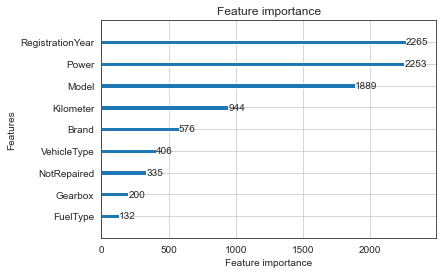

In [78]:
lgb.plot_importance(model_lgbm)

Наиболее важными признаками является:
1. RegistrationYear
2. Power
3. Model

У CatBoostRegressor и LGBMRegressor сошлись наиболее значимые признаки (RegistrationYear, Power).

У RandomForestRegressor самым важными оказались те признаки, которые у двух предыдущих моделей стоят на 3\4 месте и 5\6 месте, что говорит о том, что стандартные модели и модели, которые умеют работать с категориями, по разному оценивают важность признаков.

### Сделаем своднуб таблицу для сравнений

In [79]:
d = {'Model_name': ['RandomForestRegressor', 'LinearRegression', 'CatBoostRegressor', 'LGBMRegressor'],
     'RMSE': [1575, 3414, 1494, 1569], 
     'Fit_time_second' : [46.7, 0.0499, 389, 149], 
     'Predict_time_second' : [1.9, 0.00598, 0.637, 0.633]}
df = pd.DataFrame(data=d)

In [80]:
df.sort_values(by=['RMSE', 'Fit_time_second'])

,Model_name,RMSE,Fit_time_second,Predict_time_second
2,CatBoostRegressor,1494,389.0000,0.63700
3,LGBMRegressor,1569,149.0000,0.63300
0,RandomForestRegressor,1575,46.7000,1.90000
1,LinearRegression,3414,0.0499,0.00598


1. Наилучший показатель RMSE получился у модели CatBoostRegressor, но в тоже время это самая медленная модель.
2. У моделей LGBMRegressor и RandomForestRegressor показатель RMSE почти равен, но RandomForestRegressor обучатся быстрее, однако для этого необходимо обрабатывать категориальные признаки и присенять различные методы кодировки данных, для того, чтобы определить какой метод эффективней.
3. Можно считать, что LGBMRegressor это компромис между качеством предсказаний и скоростью обучения, а так же имеет такую же удобную функцию, как и CatBoostRegressor, обучение категориальных признаков.